### Домашнее задание

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv('./../../2Урок/lection2_materials/articles.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("./../../2Урок/lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


##### 1. Получаем векторные представления новостей

In [4]:
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2  # pip install pymorphy2

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)
morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('./../../2Урок/lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n|\\nn|\\xnn|nn", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
#     text = re.sub(r'n', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Progs\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 27.3 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 6s


In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [11]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 32.8 s


In [12]:
from gensim.test.utils import datapath 
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [13]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: который это год россия страна российский человек
topic_1: украина украинский пациент фонд лечение тыс иран
topic_2: год это новый мочь сша проект который
topic_3: статья поверхность восток врач ст вода озеро
topic_4: продукция товар авария торговый тыс понятие выяснить
topic_5: лётчик грузия ми казахстан балтийский латвия литва
topic_6: обнаружить мужчина тело женщина станция произойти дом
topic_7: фестиваль мероприятие программа пройти участник сайт организатор
topic_8: калининградский адмирал гонконг ильин кузнецов никифоров цыган
topic_9: доллар дальневосточный армия дед информировать высота эльвира
topic_10: писать сообщество связанный век опрос годовой вероятно
topic_11: год мозг смерть суд компания дело группа
topic_12: гражданин путин погибнуть фронт народный пресссекретарить песок
topic_13: ракета земля выяснить рейс установить опубликовать статья
topic_14: год это который мочь дело всё слово
topic_15: пенсия офицер азия свет предсказать сербия экономить
topic_16: ступ

In [14]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.921839,0.0,0.069617,0.0,0.0,0.0
1,4896,0.485120,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.141529,0.000000,0.0,0.000000,0.0,0.236712,0.0,0.0,0.0
2,4897,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.017726,0.018446,...,0.0,0.000000,0.000000,0.0,0.476196,0.0,0.468478,0.0,0.0,0.0
3,4898,0.037984,0.0,0.38281,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.298191,0.0,0.000000,0.0,0.098053,0.0,0.0,0.0
4,4899,0.061891,0.0,0.00000,0.0,0.029506,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.152591,0.0,0.139153,0.0,0.0,0.0


#### Следующий шаг - векторные представления пользователей

In [16]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [17]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [18]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, axis=0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [19]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.234682,0.089817,0.137540,0.004149,0.032447,0.008826,0.040400,0.018287,0.0,...,0.000000,0.030809,0.104900,0.007938,0.044968,0.000000,0.000000,0.016646,0.004860,0.003081
1,u108690,0.399952,0.064253,0.076292,0.002461,0.000000,0.003825,0.024302,0.000000,0.0,...,0.000000,0.002051,0.076810,0.000000,0.098564,0.007080,0.000000,0.018193,0.000000,0.007642
2,u108339,0.363789,0.009020,0.038322,0.015154,0.000000,0.000000,0.070326,0.000000,0.0,...,0.002273,0.000000,0.040447,0.012771,0.119412,0.010569,0.004899,0.048134,0.028468,0.006297


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [20]:
target = pd.read_csv("./../../2Урок/lection2_materials/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [21]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.234682,0.089817,0.137540,0.004149,0.032447,0.008826,0.040400,0.018287,0.0,...,0.030809,0.104900,0.007938,0.044968,0.000000,0.000000,0.016646,0.004860,0.003081,0
1,u108690,0.399952,0.064253,0.076292,0.002461,0.000000,0.003825,0.024302,0.000000,0.0,...,0.002051,0.076810,0.000000,0.098564,0.007080,0.000000,0.018193,0.000000,0.007642,1
2,u108339,0.363789,0.009020,0.038322,0.015154,0.000000,0.000000,0.070326,0.000000,0.0,...,0.000000,0.040447,0.012771,0.119412,0.010569,0.004899,0.048134,0.028468,0.006297,1


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [23]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [24]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0899928 , 0.00532348, 0.35987084, 0.13315945, 0.06715688,
       0.05124581, 0.20555671, 0.01703621, 0.06939671, 0.19032762])

In [26]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [27]:
results=[]

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.253067, F-Score=0.733, Precision=0.701, Recall=0.767


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1675   80]
 [  58  187]]


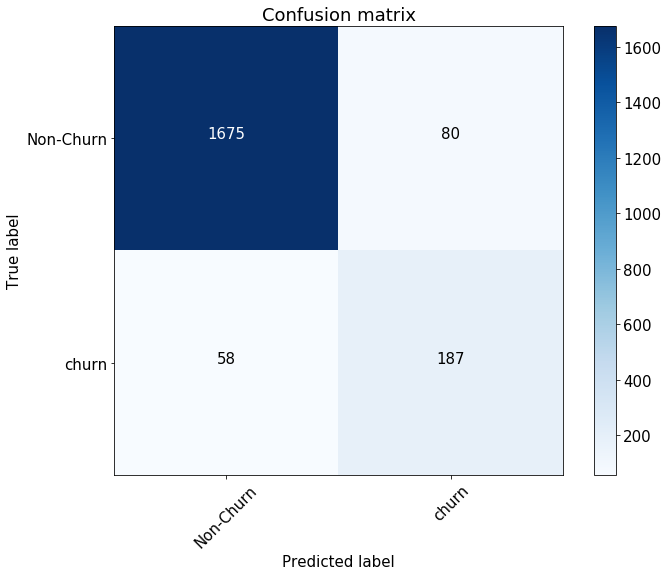

In [30]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [31]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9574417117274261

In [32]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 2
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)


In [33]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [34]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.174023,0.000000,0.062642,0.000000,0.0,0.0,0.017850,0.0,0.0,...,0.0,0.0,0.008503,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,u108690,0.360656,0.059985,0.052938,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.060252,0.000000,0.077835,0.0,0.0,0.013641,0.000000,0.0
2,u108339,0.301365,0.000000,0.022018,0.013108,0.0,0.0,0.025475,0.0,0.0,...,0.0,0.0,0.021256,0.005098,0.148297,0.0,0.0,0.046770,0.015527,0.0


In [35]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.174023,0.000000,0.062642,0.000000,0.0,0.0,0.017850,0.0,0.0,...,0.0,0.008503,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0
1,u108690,0.360656,0.059985,0.052938,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.060252,0.000000,0.077835,0.0,0.0,0.013641,0.000000,0.0,1
2,u108339,0.301365,0.000000,0.022018,0.013108,0.0,0.0,0.025475,0.0,0.0,...,0.0,0.021256,0.005098,0.148297,0.0,0.0,0.046770,0.015527,0.0,1


In [36]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [37]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16990227, 0.00684006, 0.42868359, 0.13454884, 0.03397411,
       0.04300931, 0.13732342, 0.07344287, 0.04329723, 0.18950493])

In [39]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.254221, F-Score=0.743, Precision=0.700, Recall=0.792


In [40]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9672469329612187

Confusion matrix, without normalization
[[1672   83]
 [  52  193]]


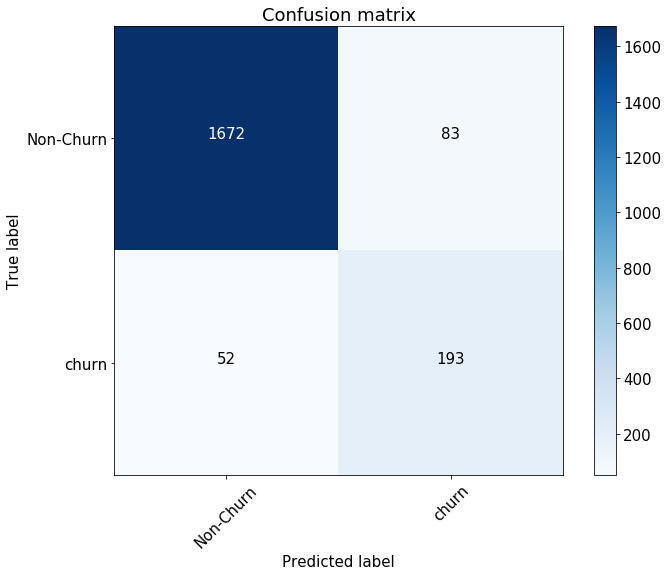

In [41]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [42]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 3
Повторить п.2, но используя уже не медиану, а max

In [43]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, axis=0)
    return user_vector

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.633718,0.286044,0.383404,0.024896,0.194681,0.052958,0.127313,0.088149,0.0,...,0.00000,0.121972,0.398083,0.030151,0.185960,0.000000,0.000000,0.099874,0.029158,0.018483
1,u108690,0.695378,0.144980,0.187653,0.014763,0.000000,0.022952,0.119546,0.000000,0.0,...,0.00000,0.012309,0.189294,0.000000,0.265095,0.042479,0.000000,0.048230,0.000000,0.033547
2,u108339,0.647965,0.031484,0.115525,0.035365,0.000000,0.000000,0.197839,0.000000,0.0,...,0.01364,0.000000,0.125510,0.050453,0.182893,0.052602,0.016483,0.124797,0.102111,0.037782


In [45]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.633718,0.286044,0.383404,0.024896,0.194681,0.052958,0.127313,0.088149,0.0,...,0.121972,0.398083,0.030151,0.185960,0.000000,0.000000,0.099874,0.029158,0.018483,0
1,u108690,0.695378,0.144980,0.187653,0.014763,0.000000,0.022952,0.119546,0.000000,0.0,...,0.012309,0.189294,0.000000,0.265095,0.042479,0.000000,0.048230,0.000000,0.033547,1
2,u108339,0.647965,0.031484,0.115525,0.035365,0.000000,0.000000,0.197839,0.000000,0.0,...,0.000000,0.125510,0.050453,0.182893,0.052602,0.016483,0.124797,0.102111,0.037782,1


In [46]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [47]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.41074815e-02, 3.68127046e-04, 7.64026640e-01, 3.15693924e-01,
       1.60849155e-02, 2.81857690e-03, 1.28827631e-01, 1.29498506e-03,
       4.73623473e-03, 8.92414869e-02])

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.384866, F-Score=0.798, Precision=0.805, Recall=0.792


In [50]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9703889761032618

Confusion matrix, without normalization
[[1708   47]
 [  52  193]]


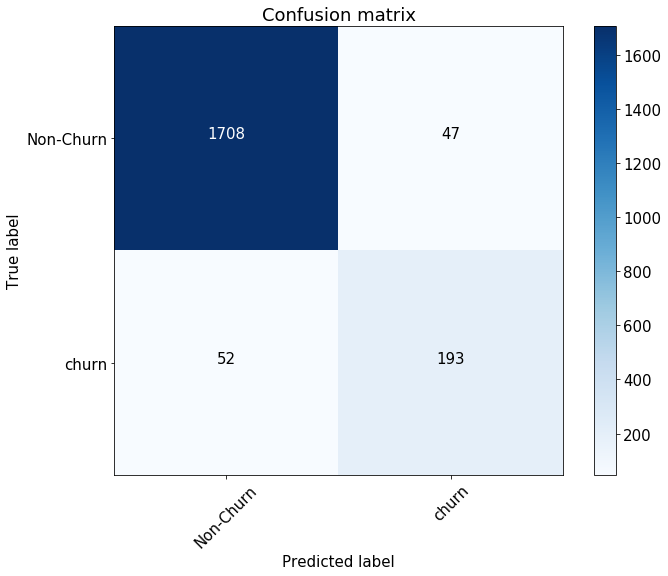

In [51]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [52]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 4*
Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(smooth_idf=True,norm=None)
vectorizer.fit(users['articles'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm=None, preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [54]:
idf_doc = dict(zip([int(name) for name in vectorizer.vocabulary_.keys()], vectorizer.idf_))

In [55]:
def get_user_embedding_idf(user_articles_list, idf_doc):
    user_articles_list = eval(user_articles_list)
#     Добавление веса idf к документам
#     user_vector = np.array([doc_dict[doc_id]*idf_doc[doc_id] for doc_id in user_articles_list])
    user_vector = np.array([doc_dict[doc_id]*idf_doc[doc_id] if doc_id in idf_doc.keys() else doc_dict[doc_id]*8 for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, axis=0)
    return user_vector

In [56]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_idf(x, idf_doc), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,2.036867,0.762651,1.153113,0.036882,0.256586,0.078455,0.341123,0.150102,0.0,...,0.000000,0.256630,0.864950,0.066304,0.387866,0.000000,0.000000,0.133855,0.043196,0.027382
1,u108690,3.452487,0.592601,0.684575,0.021163,0.000000,0.035553,0.212054,0.000000,0.0,...,0.000000,0.019067,0.704772,0.000000,0.881287,0.065801,0.000000,0.153030,0.000000,0.067531
2,u108339,3.229357,0.078668,0.336636,0.136899,0.000000,0.000000,0.630177,0.000000,0.0,...,0.019045,0.000000,0.372500,0.116055,1.044158,0.098230,0.042443,0.430380,0.250249,0.055972


In [57]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,2.036867,0.762651,1.153113,0.036882,0.256586,0.078455,0.341123,0.150102,0.0,...,0.256630,0.864950,0.066304,0.387866,0.000000,0.000000,0.133855,0.043196,0.027382,0
1,u108690,3.452487,0.592601,0.684575,0.021163,0.000000,0.035553,0.212054,0.000000,0.0,...,0.019067,0.704772,0.000000,0.881287,0.065801,0.000000,0.153030,0.000000,0.067531,1
2,u108339,3.229357,0.078668,0.336636,0.136899,0.000000,0.000000,0.630177,0.000000,0.0,...,0.000000,0.372500,0.116055,1.044158,0.098230,0.042443,0.430380,0.250249,0.055972,1


In [58]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [59]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

C:\Progs\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([3.67271664e-02, 9.45890539e-08, 8.45652038e-01, 4.46448148e-02,
       3.08001139e-02, 1.07541032e-02, 6.34589659e-02, 7.91739817e-06,
       9.10628269e-04, 1.16691915e-01])

In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.362567, F-Score=0.793, Precision=0.760, Recall=0.829


In [62]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9738101052386767

Confusion matrix, without normalization
[[1691   64]
 [  43  202]]


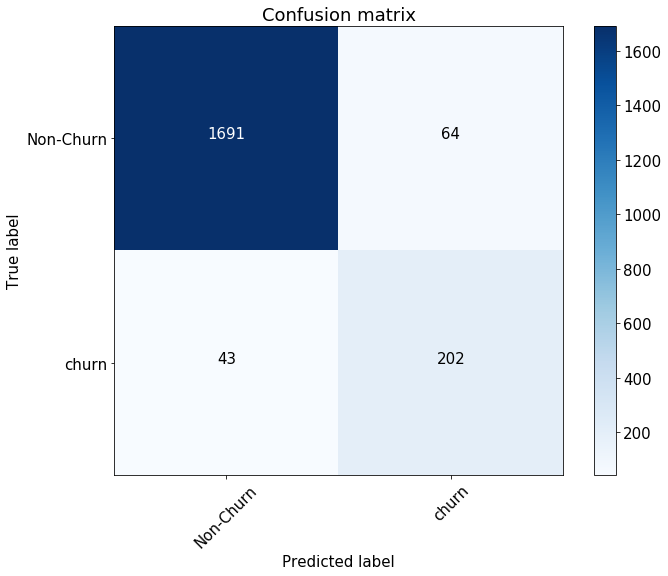

In [63]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [64]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 5
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [65]:
res = pd.DataFrame(results, columns=['Precision','Recall','Fscore','Roc_auc'])
res['Method']=['mean','median','max','idf']
res

,Precision,Recall,Fscore,Roc_auc,Method
0,0.701493,0.767347,0.732943,0.957442,mean
1,0.700361,0.791837,0.743295,0.967247,median
2,0.804979,0.791837,0.798354,0.970389,max
3,0.760300,0.828571,0.792969,0.973810,idf


Так как наш набор данных имеет сильный дисбаланс классов, то параметр Roc_auc не сильно показательный.
Лучшими себя показали методы idf и max. В первом меньше точность, но лучше полнота, во втором наоборот. Fмера у них примерно одинакова.\
Метод max все темы считает приоритетными, нулевыми остаются только те, которые пользователь никогда не читал.